In [1]:
#import ROOT
import numpy as np
from array import *
import matplotlib.pyplot as plt
import dunestyle.matplotlib as dunestyle


DUNE plot style enabled


In [17]:
import numpy as np
import uproot
import awkward as ak

# ----------------------------
# User inputs
# ----------------------------
ROOT_FILE = "/home/leoperes/ntuples_grid_newVertex/00a_newVertex/atm_hA_BR.root"
TREE_PATH = "ana/Atm"  # change if your tree path is different
VERTEX_BRANCH = "MCInitialPositionNu"



# Vertex reconstruction 1-sigma uncertainties (same units as the ntuple)
dx = 0.21
dy = 0.39
dz = 0.23

N_TOYS = 5000   # increase to 2000+ for final numbers
SEED = 12345

# Optional: event weights branch name (set to None if you don't use weights)
WEIGHT_BRANCH = None  # e.g. "weight", "evtWeight", etc.





In [15]:

def vertices_to_xyz(vtx):
    """
    Convert PrimaryRecoVertex into x,y,z numpy arrays.

    Supports:
      - (N,3)
      - (N,1,3)  (common: one vertex stored as a length-1 list per event)
      - awkward record/struct with fields x,y,z (or fX,fY,fZ, etc.)
    """
    if isinstance(vtx, ak.Array):
        # Case 1: record/struct with fields
        if hasattr(vtx, "fields") and len(vtx.fields) > 0:
            fields = set(vtx.fields)
            candidates = [
                ("x", "y", "z"),
                ("X", "Y", "Z"),
                ("fX", "fY", "fZ"),
                ("fx", "fy", "fz"),
            ]
            for fx, fy, fz in candidates:
                if fx in fields and fy in fields and fz in fields:
                    return (ak.to_numpy(vtx[fx]),
                            ak.to_numpy(vtx[fy]),
                            ak.to_numpy(vtx[fz]))
            raise ValueError(f"Vertex branch is a record, but fields {vtx.fields} are not recognized.")

        # Case 2: numeric array-like
        arr = ak.to_numpy(vtx)
        #print(arr)

        # Handle (N,1,3) -> (N,3)
        if arr.ndim == 3 and arr.shape[1] == 1 and arr.shape[2] == 3:
            arr = arr[:, 0, :]  # squeeze the middle axis

        if arr.ndim == 2 and arr.shape[1] == 3:
            return arr[:, 0], arr[:, 1], arr[:, 2]

        raise ValueError(f"Unrecognized awkward vertex layout with shape {arr.shape}.")

    # numpy input fallback
    arr = np.asarray(vtx)
    if arr.ndim == 3 and arr.shape[1] == 1 and arr.shape[2] == 3:
        arr = arr[:, 0, :]
    if arr.ndim == 2 and arr.shape[1] == 3:
        return arr[:, 0], arr[:, 1], arr[:, 2]

    raise ValueError(f"Unrecognized vertex layout with numpy shape {arr.shape}.")


In [16]:
import numpy as np

def in_fiducial(x, y, z,
                xmin=-359.0, xmax=359.0,
                ymin=-604.0, ymax=604.0,
                zmin=0.0,   zmax=1394.0):
    """
    Fiducial-volume (or detector active volume) cut using explicit bounds:
      -359 < x < 359
      -604 < y < 604
         0 < z < 1394
    Works with numpy arrays or scalars.
    """
    return (x > xmin) & (x < xmax) & (y > ymin) & (y < ymax) & (z > zmin) & (z < zmax)

# ----------------------------
# Main
# ----------------------------
def compute_vertex_fv_systematic(
    root_file,
    tree_path,
    vertex_branch,
    dx, dy, dz,
    n_toys=500,
    seed=12345,
    weight_branch=None,
    smear_model="gaussian",  # "gaussian" or "uniform"
):
    rng = np.random.default_rng(seed)

    with uproot.open(root_file) as f:
        tree = f[tree_path]

        branches = [vertex_branch]
        if weight_branch is not None:
            branches.append(weight_branch)

        data = tree.arrays(branches, library="ak")

    x, y, z = vertices_to_xyz(data[vertex_branch])

    #print(x,y,z)
    if weight_branch is None:
        w = np.ones_like(x, dtype=float)
    else:
        w = ak.to_numpy(data[weight_branch]).astype(float)

    #print(w)
    # Nominal FV selection
    mask_nom = in_fiducial(x, y, z)  # uses defaults above

    W_nom = np.sum(w[mask_nom])
    W_tot = np.sum(w)

    if W_nom <= 0:
        raise RuntimeError("Nominal selected weight is zero (check FV bounds, units, or branch content).")

    # Toy results
    rel_shifts = np.empty(n_toys, dtype=float)

    for t in range(n_toys):
        if smear_model == "gaussian":
            xs = x + rng.normal(0.0, dx, size=x.shape)
            ys = y + rng.normal(0.0, dy, size=y.shape)
            zs = z + rng.normal(0.0, dz, size=z.shape)
        elif smear_model == "uniform":
            # uniform in [-dx, +dx], etc.
            xs = x + rng.uniform(-dx, +dx, size=x.shape)
            ys = y + rng.uniform(-dy, +dy, size=y.shape)
            zs = z + rng.uniform(-dz, +dz, size=z.shape)
        else:
            raise ValueError("smear_model must be 'gaussian' or 'uniform'.")

        mask_toy = in_fiducial(xs, ys, zs)

        W_toy = np.sum(w[mask_toy])

        rel_shifts[t] = (W_toy - W_nom) / W_nom

    # Systematic summaries
    syst_rms = np.std(rel_shifts, ddof=1)
    syst_env = np.max(np.abs(rel_shifts))

    plt.figure(figsize=(8,6))
    plt.hist(rel_shifts*100, bins=50, histtype='stepfilled', color='C0', alpha=0.7)
    plt.title("Vertex FV systematic variations", fontsize=16)
    plt.xlabel("Relative shift in selected events (%)", fontsize=14)
    plt.ylabel("Toys", fontsize=14)     
    plt.legend([f"RMS = {syst_rms*100:.4f} %\nEnvelope = {syst_env*100:.4f} %"], fontsize=12)
    plt.show()

    out = {
        "W_tot": W_tot,
        "W_nom": W_nom,
        "nominal_eff": W_nom / W_tot if W_tot > 0 else np.nan,
        "rel_shifts": rel_shifts,
        "syst_rms": syst_rms,
        "syst_envelope": syst_env,
        "mean_shift": float(np.mean(rel_shifts)),
        "p16": float(np.percentile(rel_shifts, 16)),
        "p84": float(np.percentile(rel_shifts, 84)),
    }
    return out


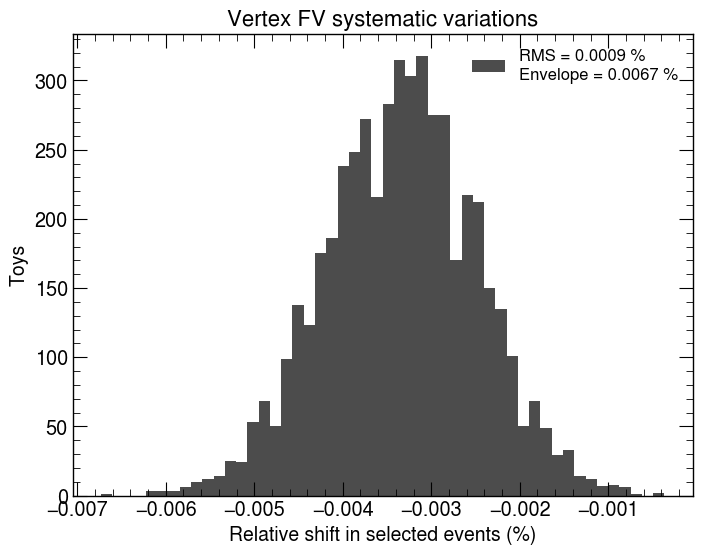

=== Vertex FV systematic from smearing PrimaryRecoVertex ===
W_tot            = 3.01996e+06
W_nom (in FV)    = 3.01495e+06
Nominal eff      = 0.998341
Mean rel shift   = -3.34081e-05
16-84% band      = [-4.21234e-05, -2.4876e-05]
Syst (RMS)       = 8.54325e-06  (typical choice)
Syst (envelope)  = 6.73311e-05  (conservative)


In [18]:


if __name__ == "__main__":
    res = compute_vertex_fv_systematic(
        root_file=ROOT_FILE,
        tree_path=TREE_PATH,
        vertex_branch=VERTEX_BRANCH,
        dx=dx, dy=dy, dz=dz,
        n_toys=N_TOYS,
        seed=SEED,
        weight_branch=WEIGHT_BRANCH,
        smear_model="gaussian"
    )

    print("=== Vertex FV systematic from smearing PrimaryRecoVertex ===")
    print(f"W_tot            = {res['W_tot']:.6g}")
    print(f"W_nom (in FV)    = {res['W_nom']:.6g}")
    print(f"Nominal eff      = {res['nominal_eff']:.6g}")
    print(f"Mean rel shift   = {res['mean_shift']:.6g}")
    print(f"16-84% band      = [{res['p16']:.6g}, {res['p84']:.6g}]")
    print(f"Syst (RMS)       = {res['syst_rms']:.6g}  (typical choice)")
    print(f"Syst (envelope)  = {res['syst_envelope']:.6g}  (conservative)")

In [58]:
import numpy as np

# detector bounds
XMIN, XMAX = -363.0, 363.0
YMIN, YMAX = -608.0, 608.0
ZMIN, ZMAX = 0.0, 1394.0

def in_fiducial(x, y, z):
    return (x > XMIN) & (x < XMAX) & (y > YMIN) & (y < YMAX) & (z > ZMIN) & (z < ZMAX)

def fraction_within_3sigma_of_borders(x, y, z, dx, dy, dz, only_nominal_in_fv=True, nsigma=3.0):
    """
    Returns fractions of events that are within nsigma*sigma of any detector boundary plane.
    If only_nominal_in_fv=True, compute fraction among events nominally inside FV.
    """
    x = np.asarray(x); y = np.asarray(y); z = np.asarray(z)

    # distances to each plane (positive inside, negative if outside)
    d_xmin = x - XMIN
    d_xmax = XMAX - x
    d_ymin = y - YMIN
    d_ymax = YMAX - y
    d_zmin = z - ZMIN
    d_zmax = ZMAX - z

    # within nsigma*sigma of any plane (coordinate-wise thresholds)
    near_x = (d_xmin < nsigma * dx) | (d_xmax < nsigma * dx)
    near_y = (d_ymin < nsigma * dy) | (d_ymax < nsigma * dy)
    near_z = (d_zmin < nsigma * dz) | (d_zmax < nsigma * dz)

    near_any_border = near_x | near_y | near_z

    # choose denominator
    if only_nominal_in_fv:
        denom_mask = in_fiducial(x, y, z)
    else:
        denom_mask = np.ones_like(near_any_border, dtype=bool)

    denom = denom_mask.sum()
    if denom == 0:
        raise RuntimeError("Denominator is zero (no events in the chosen sample).")

    num = (near_any_border & denom_mask).sum()

    frac_near = num / denom
    frac_safe = 1.0 - frac_near

    return {
        "denominator_events": int(denom),
        "near_border_events": int(num),
        "frac_near_border": float(frac_near),
        "frac_safe_core": float(frac_safe),
    }


# Fraction among NOMINAL-IN-FV events (usually what you want for migration studies)
res_in = fraction_within_3sigma_of_borders(x, y, z, dx, dy, dz, only_nominal_in_fv=True, nsigma=3.0)

# Fraction among ALL events (useful diagnostic)
res_all = fraction_within_3sigma_of_borders(x, y, z, dx, dy, dz, only_nominal_in_fv=False, nsigma=3.0)

print("=== Within 3σ of borders (among nominal IN-FV) ===")
print(res_in)

print("\n=== Within 3σ of borders (among ALL events) ===")
print(res_all)


=== Within 3σ of borders (among nominal IN-FV) ===
{'denominator_events': 3013151, 'near_border_events': 56505, 'frac_near_border': 0.01875279400202645, 'frac_safe_core': 0.9812472059979735}

=== Within 3σ of borders (among ALL events) ===
{'denominator_events': 3019964, 'near_border_events': 63318, 'frac_near_border': 0.020966475097054137, 'frac_safe_core': 0.9790335249029458}
